Mike Cresswell: Feature Engineering and Selection

In [9]:
import pandas as pd
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import requests
import os
import io

In [ ]:
url="https://raw.githubusercontent.com/mgcresswell/TCSS555-Project/main/deceptive-opinion_processed.csv"
s=requests.get(url).content
processed = pd.read_csv(io.StringIO(s.decode('utf-8'))) 

url="https://raw.githubusercontent.com/mgcresswell/TCSS555-Project/main/deceptive-opinion.csv"
s=requests.get(url).content
raw = pd.read_csv(io.StringIO(s.decode('utf-8'))) 

In [ ]:
y = processed['deceptive']
X = processed.drop(['id','deceptive'], axis=1)

#Feature Engineering
punc = ['`','~','!','(',')','_','-','{','[','}','}',':',';','"',',','.','?','/','""']
X['word_count'] = raw["text"].apply(lambda x: len(str(x).split(" ")))
X['char_count'] = raw["text"].apply(lambda x: sum(len(word) for word in str(x).split(" ")))
X['sentence_count'] = raw["text"].apply(lambda x: len(str(x).split(".")))
X['avg_word_length'] = X['char_count'] / X['word_count']
X['avg_sentence_length'] = X['word_count'] / X['sentence_count']
X['word_density'] = X['word_count'] / (X['char_count'] + 1)
X['punc_count'] = raw['text'].apply(lambda x : len([a for a in x if a in punc]))
X['total_length'] = raw['text'].apply(len)
X['capitals'] = raw['text'].apply(lambda comment: sum(1 for c in comment if c.isupper()))
X['num_exclamation_marks'] = raw['text'].apply(lambda x: x.count('!'))
X['num_question_marks'] = raw['text'].apply(lambda x: x.count('?'))
X['num_punctuation'] = raw['text'].apply(lambda x: sum(x.count(w) for w in '.,;:'))
X['num_symbols'] = raw['text'].apply(lambda x: sum(x.count(w) for w in '*&$%'))
X['num_unique_words'] = raw['text'].apply(lambda x: len(set(w for w in x.split())))
X['words_vs_unique'] = X['num_unique_words'] / X['word_count']
X["word_unique_percent"] =  X["num_unique_words"]*100/X['word_count']

In [ ]:
#Pre-process features before selection 
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
hotelEncoded = label_encoder.fit_transform(X['hotel'])
polarityEncoded = label_encoder.fit_transform(X['polarity'])
sourceEncoded = label_encoder.fit_transform(X['source'])

onehot_encoder = OneHotEncoder(sparse=False)
hotelEncoded = hotelEncoded.reshape(len(hotelEncoded), 1)
X['hotel'] = onehot_encoder.fit_transform(hotelEncoded)
polarityEncoded = polarityEncoded.reshape(len(polarityEncoded), 1)
X['polarity'] = onehot_encoder.fit_transform(polarityEncoded)
sourceEncoded = sourceEncoded.reshape(len(sourceEncoded), 1)
X['source'] = onehot_encoder.fit_transform(sourceEncoded)

Tfidf_vect = TfidfVectorizer(max_features=3500)
Tfidf_vect.fit(X['text'])
Train_X_Tfidf = Tfidf_vect.transform(processed['text'])
X['text'] = Train_X_Tfidf.toarray()

In [ ]:
#Analyze features with SelectKBest
bestfeatures = SelectKBest(score_func=chi2, k=19)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

#View SelectKBest Feature Rankings
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']
featureScores.nlargest(19,'Score')

,Specs,Score
2,source,800.000000
10,punc_count,569.295939
11,total_length,424.318223
5,char_count,368.918057
15,num_punctuation,234.943533
16,num_symbols,221.802198
6,sentence_count,207.283962
17,num_unique_words,105.019006
8,avg_sentence_length,97.198065
4,word_count,56.948712


[7.66569515e-04 1.74776685e-03 9.21010562e-01 1.33925243e-04
 2.97088472e-03 2.68248748e-03 7.54002670e-03 2.47378919e-03
 7.44221880e-03 2.34485591e-03 1.00814561e-02 2.80473558e-03
 3.35122357e-03 2.84755250e-03 1.76048946e-03 5.09946379e-03
 1.29536863e-02 2.69754802e-03 5.20264200e-03 4.08811620e-03]


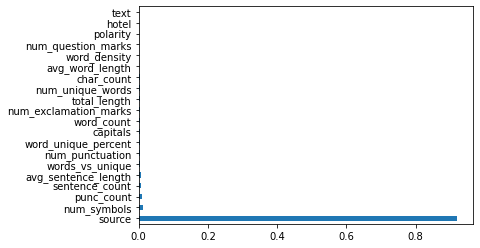

In [ ]:
#Analyze features with ExtractTreeClassifier
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)

#Plot ExtractTreeClassifier Rankings
feat_importances.nlargest(20).plot(kind='barh')
plt.show()